In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.easter import easter
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
df = cfs.load_df()
melted_df = cfs.melt_data(df)
chicago_df = df[(df['Metro'] == 'Chicago') & (df['State'] == 'IL')]
chicago_df['ROI_5yrs'] = ((chicago_df['2018-04'] - chicago_df['2013-04'])/chicago_df['2013-04'])*100
chicago_df['ROI_2yrs'] = ((chicago_df['2018-04'] - chicago_df['2016-04'])/chicago_df['2016-04'])*100
top_30 = chicago_df.sort_values('ROI_5yrs', ascending=False)[:100].sort_values('ROI_2yrs', ascending=False)[:30].RegionName

In [4]:
chicago_top_30 = pd.DataFrame()
chicago_top_30['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')
chicago_top_30.set_index('time', inplace=True)
for region in top_30.values:
    chicago_top_30[region] = melted_df[melted_df['RegionName'] == region].value.values

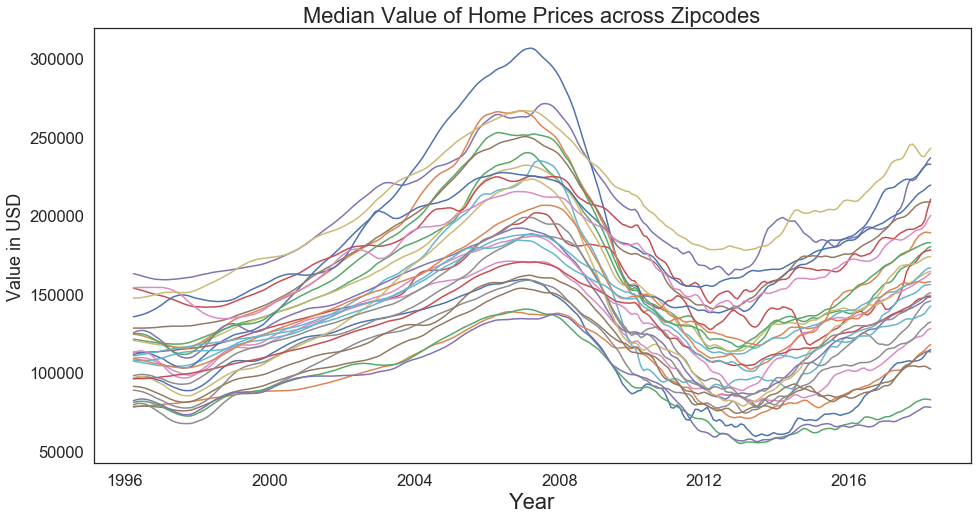

<Figure size 432x288 with 0 Axes>

In [5]:
#NOTE: chicago_top_30.plot() didn't work, had to run a for loop to get this
sns.set(font_scale=1.5)
sns.set_style('white')
plt.figure(figsize=(14,8))
for i in range(chicago_top_30.shape[1]):
    plt.plot(chicago_top_30.index, chicago_top_30.iloc[:, i])
plt.xlabel('Year', fontsize=22)
plt.ylabel('Value in USD', fontsize=18)
plt.title('Median Value of Home Prices across Zipcodes', fontsize=22)
plt.show()
plt.savefig('market');

In [6]:
def train_test_split(df, train_start, train_end, test_start):
    
    train = df[train_start:train_end]
    test = df[test_start:]

    return train, test


In [7]:
train, test = train_test_split(chicago_top_30, '2013-01-01', '2017-10-01', '2017-10-01')

In [8]:
train.head()

,60085,60436,60163,60034,60180,60633,60099,60505,60162,60165,...,60447,60155,60164,60435,60411,60139,60178,60104,60185,60097
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,67100.0,71600.0,115400.0,136700.0,165300.0,84600.0,84900.0,75800.0,113600.0,95500.0,...,160500.0,105700.0,116500.0,105100.0,56300.0,143000.0,142800.0,84500.0,178800.0,103000.0
2013-02-01,66600.0,71000.0,116500.0,135800.0,165900.0,83800.0,83900.0,74200.0,114400.0,95300.0,...,161500.0,104600.0,117500.0,104700.0,56300.0,144100.0,145300.0,83700.0,178000.0,101600.0
2013-03-01,64300.0,70600.0,116800.0,133700.0,166800.0,83000.0,82500.0,74000.0,115800.0,95200.0,...,163000.0,103300.0,118900.0,104300.0,57100.0,145600.0,145800.0,84200.0,177800.0,101000.0
2013-04-01,62400.0,70700.0,116300.0,130800.0,167400.0,82100.0,82600.0,74900.0,116900.0,95600.0,...,164200.0,102000.0,120300.0,104500.0,57500.0,147000.0,144800.0,85300.0,178200.0,100700.0
2013-05-01,60200.0,71100.0,115900.0,129200.0,169100.0,80600.0,81800.0,76200.0,118000.0,96300.0,...,164900.0,102200.0,121300.0,104700.0,57100.0,147700.0,145500.0,86000.0,178500.0,100600.0


In [9]:
rw_60447 = ARIMA(train[60447].values, order=(0,1,0)).fit()

In [10]:
rw_60447.aic

890.1178643099554

In [11]:
mean_squared_error(train[60447][1:], rw_60447.predict(typ='levels'))

330397.0452446907

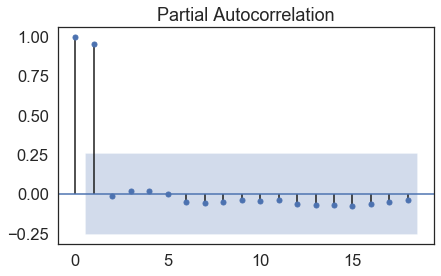

In [12]:
plot_pacf(train[60447]);

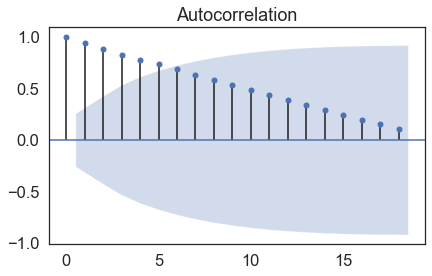

In [13]:
plot_acf(train[60447]);

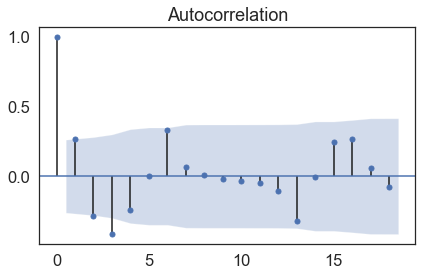

In [14]:
plot_acf(train[60447].diff().diff().dropna());

In [15]:
ar1_60447 = ARIMA(train[60447].values, order=(1,1,0), dates=train.index).fit()
ar1_60447.aic

844.6923012974953

In [16]:
mean_squared_error(train[60447][1:], ar1_60447.predict(typ='levels'))

141532.5696446458

In [17]:
auto_arima(train[60447], start_p=0, start_q=0,
           max_p=6, max_q=6, seasonal=False,
           trace=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=833.136, BIC=837.187, Time=0.015 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=834.550, BIC=840.626, Time=0.028 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=834.349, BIC=840.425, Time=0.093 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=831.273, BIC=833.299, Time=0.015 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=834.773, BIC=842.874, Time=0.226 seconds
Near non-invertible roots for order (1, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.386 seconds


ARIMA(order=(0, 2, 0), with_intercept=False)

In [18]:
arima_60447 = ARIMA(train[60447].values, order=(1,2,1), dates=train.index).fit()
arima_60447.aic

829.3700196128952

In [19]:
mean_squared_error(train[60447][2:], arima_60447.predict(typ='levels'))

137478.78329136697

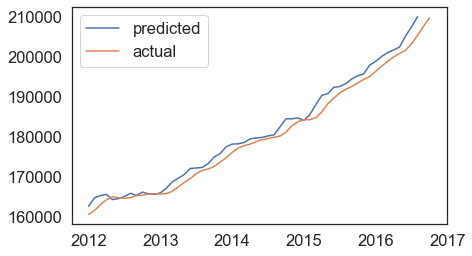

In [20]:
y_hat_train = arima_60447.predict(typ='levels')

fig,ax = plt.subplots()
ax.plot(y_hat_train, label='predicted')
ax.plot(train[60447].values, label='actual')
ax.set_xticks(list(range(0, 72, 12)))
ax.set_xticklabels(list(range(2012, 2019)))
plt.legend();

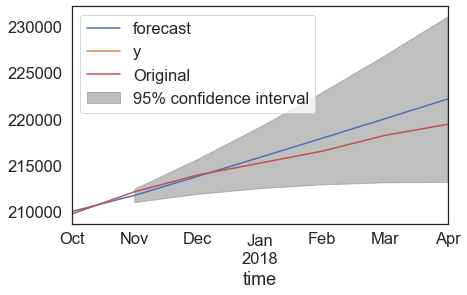

In [21]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(sharex=True, )
arima_60447.plot_predict(start='2017-10-01' , end='2018-04-01', ax=ax);
test[60447].plot(ax=ax, label='Original', color='r')
ax.legend(loc='upper left');

In [22]:
len(train[60447].index)
len(y_hat_train)

56

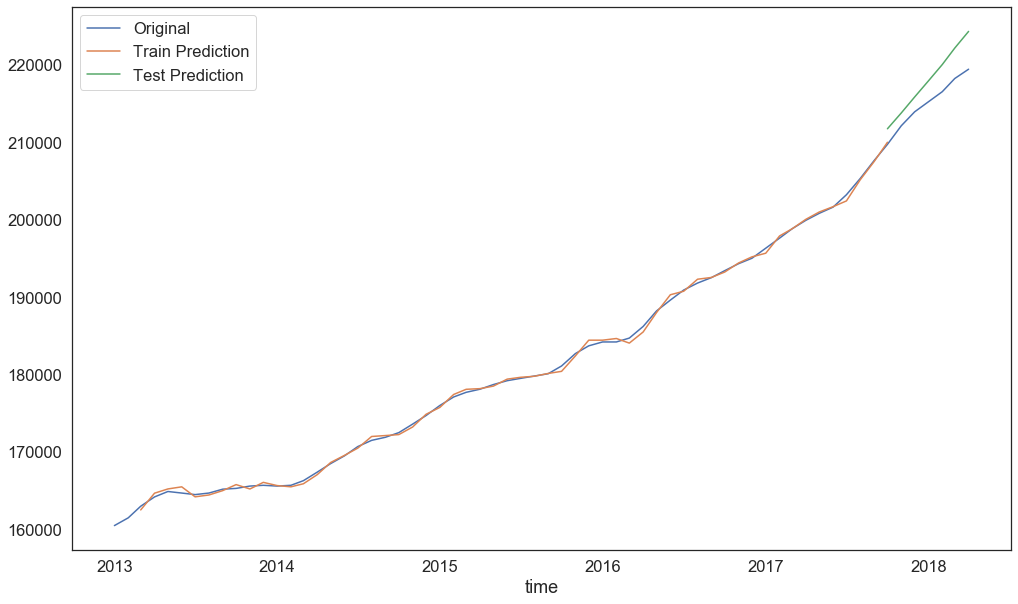

In [23]:
y_hat_train = arima_60447.predict(typ='levels')
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})
splot = sns.lineplot(x=chicago_top_30['2013-01-01':].index, y=chicago_top_30[60447]['2013-01-01':].values, label='Original')
sns.lineplot(x=train[60447][2:].index, y=y_hat_train, label='Train Prediction')
sns.lineplot(x=chicago_top_30['2017-10-01':].index, y=arima_60447.forecast(steps=7)[0], label='Test Prediction')
#ax.plot(arima_60447.forecast(steps=7)[0], label='predicted')
#ax.plot(test[60447].values, label='actual')

plt.legend();

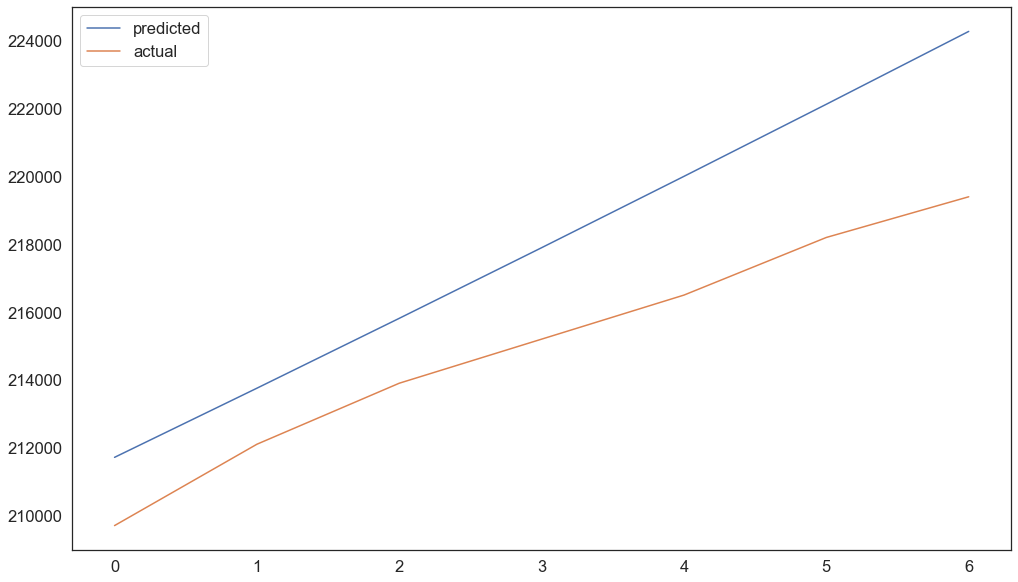

In [24]:
sns.set(font_scale=1.5)
sns.set_style('white')
f,ax = plt.subplots()
ax.plot(arima_60447.forecast(steps=7)[0], label='predicted')
ax.plot(test[60447].values, label='actual')
plt.legend();

<Figure size 1080x720 with 0 Axes>

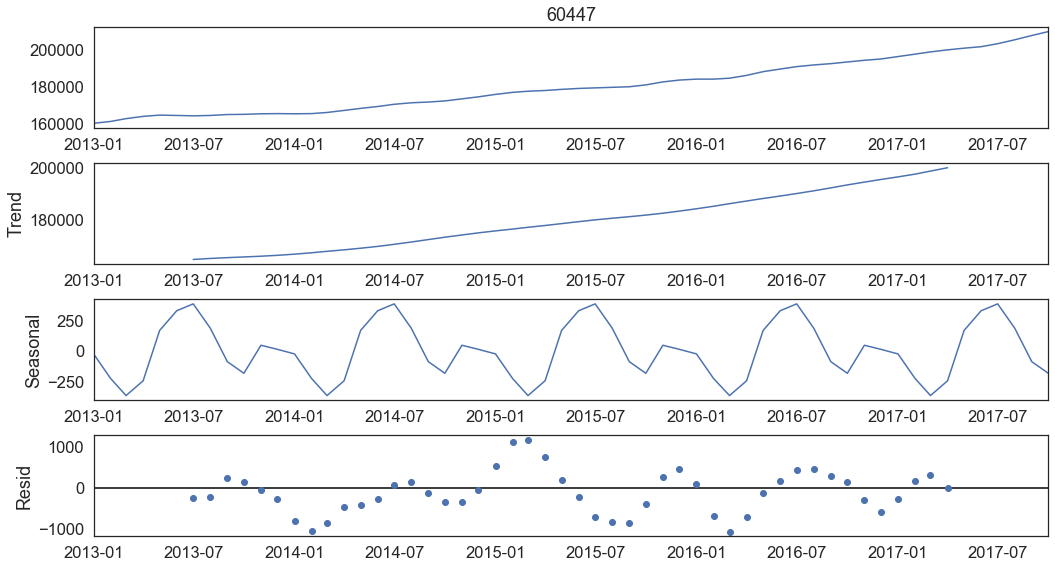

In [25]:
decomposition = seasonal_decompose(train[60447])
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8);

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
p = q = range(0, 2)
pdq = list(itertools.product(p, [2] , q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [2], q))]
print('Examples of parameter for SARIMA...')
#for i in pdq:
#    for s in seasonal_pdq:
#        print('SARIMAX: {} x {}'.format(i, s))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train[60447].values,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

Examples of parameter for SARIMA...
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:522.838992499485
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:321.34028618876874
ARIMA(0, 2, 0)x(1, 2, 0, 12) - AIC:324.6667590738401
ARIMA(0, 2, 0)x(1, 2, 1, 12) - AIC:308.5158553655683
ARIMA(0, 2, 1)x(0, 2, 0, 12) - AIC:500.00617011266974
ARIMA(0, 2, 1)x(0, 2, 1, 12) - AIC:297.7239405723158
ARIMA(0, 2, 1)x(1, 2, 0, 12) - AIC:327.39931110031836
ARIMA(0, 2, 1)x(1, 2, 1, 12) - AIC:296.1739940456918
ARIMA(1, 2, 0)x(0, 2, 0, 12) - AIC:515.8247697925858
ARIMA(1, 2, 0)x(0, 2, 1, 12) - AIC:314.3501338080465
ARIMA(1, 2, 0)x(1, 2, 0, 12) - AIC:306.51011249230646
ARIMA(1, 2, 0)x(1, 2, 1, 12) - AIC:307.4718103935561
ARIMA(1, 2, 1)x(0, 2, 0, 12) - AIC:499.1541167941982
ARIMA(1, 2, 1)x(0, 2, 1, 12) - AIC:297.372502053871
ARIMA(1, 2, 1)x(1, 2, 0, 12) - AIC:307.7447872732057
ARIMA(1, 2, 1)x(1, 2, 1, 12) - AIC:293.03891636888255


In [27]:
sarima_60447 = SARIMAX(train[60447],order=(1,2,1),seasonal_order=(1,2,1,12),
                  enforce_stationarity=False,enforce_invertibility=False).fit()
sarima_60447.aic

293.03891636888255

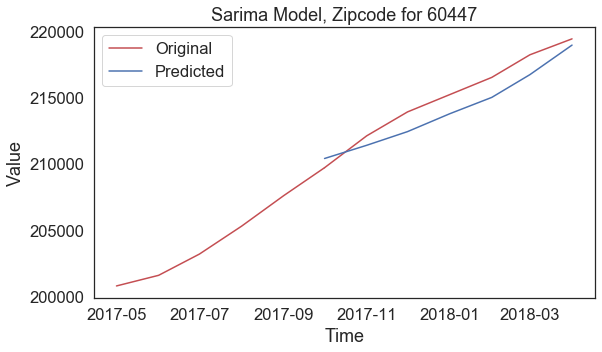

In [28]:
y_hat_train = sarima_60447.predict(typ='levels')
y_hat_test = sarima_60447.predict(start=test[60447].index[0],
                              end=test[60447].index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train[60447][52:], color='r', label='Original')
ax.plot(test[60447], color='r')
#ax.plot(y_hat_train, label='predicted', color='orange')
ax.plot(y_hat_test, color='b', label='Predicted')
ax.set_title('Sarima Model, Zipcode for 60447')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(loc='best')
f.savefig('sarima.png');
#sns.despine();

In [29]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(train[60447].values, y_hat_train))
mean_squared_error(test[60447].values, y_hat_test)

1307797974.093461


1426361.908457454

#### SARIMAX AIC looks shit